Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [1]:
### Import all the necessary libraries
#!pip install --upgrade numpy #need numppy 1.7 to use code
import scipy.io
import numpy as np
import matplotlib
import random 

from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
print(np.__version__)

Mounted at /content/drive
Using cpu device
1.21.5


In [2]:
def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)


### Import real sample data saved in google drive


In [3]:
mat_filename = '/content/drive/MyDrive/' + 'Dx_7-1_RS1_VEH_Spikes_thresh.mat'
mat = scipy.io.loadmat(mat_filename);
spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 

#import real (sample) label vector 
real_label_filename = '/content/drive/MyDrive/' + 'Dlx_C7-1_RS1_VEH_paddedLabels.mat'
label_mat = scipy.io.loadmat(real_label_filename);
label_vector= label_mat[list(label_mat.keys())[3]][0]

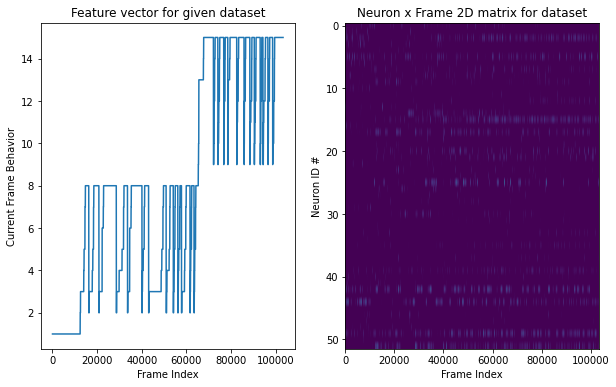

In [4]:
fig, ax = plt.subplots(1,2, figsize = (10,6))

ax[0].plot(label_vector);
ax[0].set_title("Feature vector for given dataset");
ax[0].set_xlabel('Frame Index');
ax[0].set_ylabel('Current Frame Behavior');

ax[1].imshow(spikes, aspect = 'auto');
ax[1].set_title("Neuron x Frame 2D matrix for dataset");
ax[1].set_xlabel('Frame Index');
ax[1].set_ylabel('Neuron ID #');

In [5]:
#make prediction and losses dict for later 
predictions_dict = dict()
losses_dict = dict()
report_info = dict()


new random vector shape is (1, 103362)


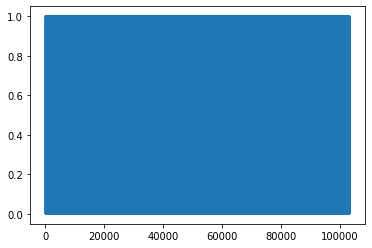

In [6]:
# make deterministic raster for testing network
random_label_vec = make_rand_labels(label_vector.shape[0])

label_mask = random_label_vec == 1
label_mask = label_mask #create numpy boolean mask for indexing

print('new random vector shape is' , random_label_vec.shape)
plt.plot(random_label_vec.ravel());

### Testing pytorch network on simulated dataset
To verify the network architecture is able to learn, a sample dataset is created, of equal size as the real calcium dataset (Neuron x Observation matrix) . This dataset has activity (defined as Element in row n, column o/E_n,o = 1)in a subset of simulated units. The network is then trained on said simulated dataset.

new raster shape is(50, 103362)


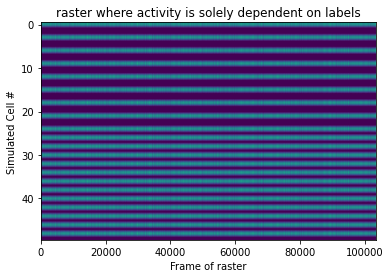

In [7]:

d_raster_size = 50
#create raster that is dependent on random labels
dependent_raster = np.zeros((d_raster_size,label_mask.shape[1]))
dependent_raster[0:round(d_raster_size/2):3, label_mask.ravel()] = 1
dependent_raster[round(d_raster_size/2)+1::2, label_mask.ravel()] = 1

print('new raster shape is' + str(dependent_raster.shape))

plt.imshow(dependent_raster, aspect = 'auto');
plt.title('raster where activity is solely dependent on labels');
plt.xlabel('Frame of raster');
plt.ylabel('Simulated Cell #');

In [8]:
## NETWORK CLASS STORAGE

#build neural network based off frost et al., with 1000 hidden layer units outputting to a single sigmoid output unit
#Most importantly, this network will use mean squared error as the loss funciton 
class frost_net(nn.Module):
    def __init__(self): #input in the number of neurons you want to use 
        super(frost_net, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.sigmoid = nn.Sigmoid()
        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #REMOVING RELU because frost et al. just feed data directly from input to hidden layer
        #x = self.relu(x)#then apply relu
        x = self.sigmoid(x) #then apply sigmoid for output
        return x


In [25]:
#replicate frost et al., architecture
# randomly set up weights from the input neurons to the hidden layer units
def make_random_connections(num_cells, num_hidden_units, connect_prob):
    #to be fed into the 1000 x 1 input/hiddne unit layer, you need it to be 1 x 1000 input matrix
    rand_matrix = np.random.rand(num_cells, num_hidden_units) <= connect_prob #everything LESS than connection problem is a 1
    return rand_matrix 

def sum_rand_connect_to_hidden_layer(random_connection_matrix, real_dataset):     #this takes a given connection matrix, and sums up each frame of the real dataset
    summed_HL_input = np.empty((real_dataset.shape[1], random_connection_matrix.shape[1] )) #number of frames BY number of HL units
#    for each unit, during each run, the input neurons are the same across the ENTIRE dataset
    for hidden_unit_ID in np.arange(random_connection_matrix.shape[1]):
        input_to_HL_unit = real_dataset[random_connection_matrix[:, hidden_unit_ID], :] #take all columns of the neurons that are boolean True connected to unit 
        summed_HL_input[:, hidden_unit_ID] = np.sum(input_to_HL_unit, axis = 0) #this outputs a boolean
    return summed_HL_input
    #turn the sum into a torch tensor
    #you want to feed out a num_frame x 1000 matrix, so when you index i it's the right input to the matrix 
    #return summed_HL_input #size iwll be num Frame rows, hidden layer columns

In [19]:
rand_conn_matrix = make_random_connections(50,1000, 0.3)
sum_input = sum_rand_connect_to_hidden_layer(rand_conn_matrix, dependent_raster[:, 0:100])
print(rand_conn_matrix.shape)

(50, 1000)


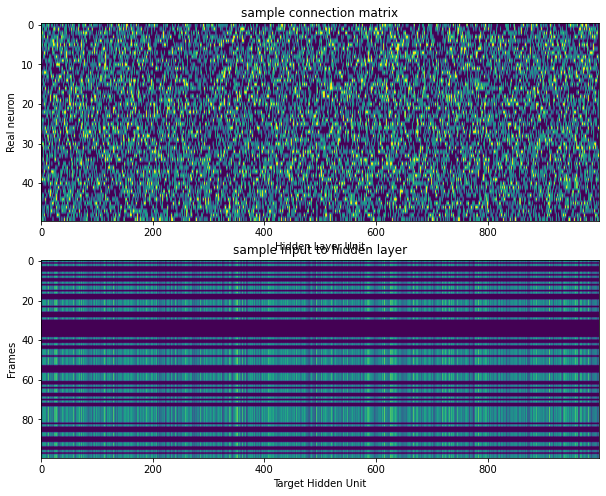

In [27]:
#show the connection matrix to verify it's working
fig, ax= plt.subplots(2, figsize = (10,8))

ax[0].imshow(rand_conn_matrix, aspect = 'auto');
ax[0].set_title('sample connection matrix');
ax[0].set_xlabel('Hidden Layer Unit');
ax[0].set_ylabel('Real neuron');

ax[1].imshow(sum_input, aspect = 'auto');
ax[1].set_title('sample input to hidden layer');
ax[1].set_xlabel('Target Hidden Unit');
ax[1].set_ylabel('Frames');

In [106]:
def train_loop_conn_matrix(connection_matrix, dataset, labels, model, loss_fn, optim_obj):
    #transform dataset to tensor form of post-transformed hidden unit input layer 
    ensemble_transform_dataset = torch.from_numpy(sum_rand_connect_to_hidden_layer(connection_matrix, dataset)) #need to convert this to a tensor
    loss_list = list()
    for example_index in np.arange(labels.shape[0]):
        #to be fed into the 1000 x 1 input/hiddne unit layer, you need it to be 1 x 1000 input matrix
        prediction = model(ensemble_transform_dataset[example_index,:]) #take the example index and slice into dataset with it 
        #print(prediction.shape, labels[example_index].view(1).shape) #for debug shape mismatch

        prediction_loss = loss_fn(prediction.float(), labels[example_index].view(1).float())
        #run backpropogation
        optim_obj.zero_grad() #clear the gradient vector
        prediction_loss.backward()# send the loss backwards through the network
        optim_obj.step()# then move the opimizer 

        if example_index %100 == 0:
            print('running example: ', example_index)
        loss_list.append(prediction_loss.item()) #.item returns the tensor's value independent from the gradient
    return loss_list


In [110]:
frost_test = frost_net()
#declare parameters
learning_rate = 0.05
#instantiate loss function and optimizer
loss_function = nn.MSELoss()
frost_optimizer = torch.optim.SGD(frost_test.parameters(), lr = learning_rate)
print('neural network params are :' , frost_test) 

#start off a run with making a rand connection matrix 
rand_conn_matrix = make_random_connections(50,1000, 0.3)
train_index_start = 0
train_index_end = 1000
print("training index size is :" , torch.from_numpy(random_label_vec[0,train_index_start:train_index_end]).shape[0])

loss_record = train_loop_conn_matrix(rand_conn_matrix, dependent_raster[:, train_index_start:train_index_end], torch.from_numpy(random_label_vec[0,train_index_start:train_index_end]), frost_test, loss_function, frost_optimizer)


neural network params are : frost_net(
  (fc1): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
training index size is : 1000
running example:  0
running example:  100
running example:  200
running example:  300
running example:  400
running example:  500
running example:  600
running example:  700
running example:  800
running example:  900


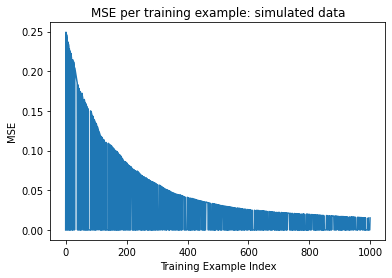

In [113]:
plt.plot(loss_record);
plt.title("MSE per training example: simulated data")
plt.xlabel("Training Example Index")
plt.ylabel('MSE');